# 0.0. Imports 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
import scikitplot as skplt

from IPython.core.display import HTML

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lr

# 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 0.2. Loading Dataset

In [4]:
df_raw = pd.read_csv( '../data/raw/train.csv' )

In [5]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0. Data Description

In [6]:
df1 = df_raw.copy()

In [7]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

## 1.1. Data Dimension

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0]))
print( 'Number of Columns: {}'.format( df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## 1.2. Data Types

In [9]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Check NA

In [10]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Data Descriptive

In [11]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [12]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. Feature Engeneering

In [13]:
df2 = df1.copy()

In [14]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else
                                                         'between_1_2_year' if x == '1-2 Year' else
                                                         'below_1_year')

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# 3.0. Data Filtering

In [15]:
df3 = df2.copy()

# 4.0. EDA

In [16]:
df4 = df3.copy()

## 4.1 Univariate Analysis

In [17]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

<Axes: xlabel='response', ylabel='age'>

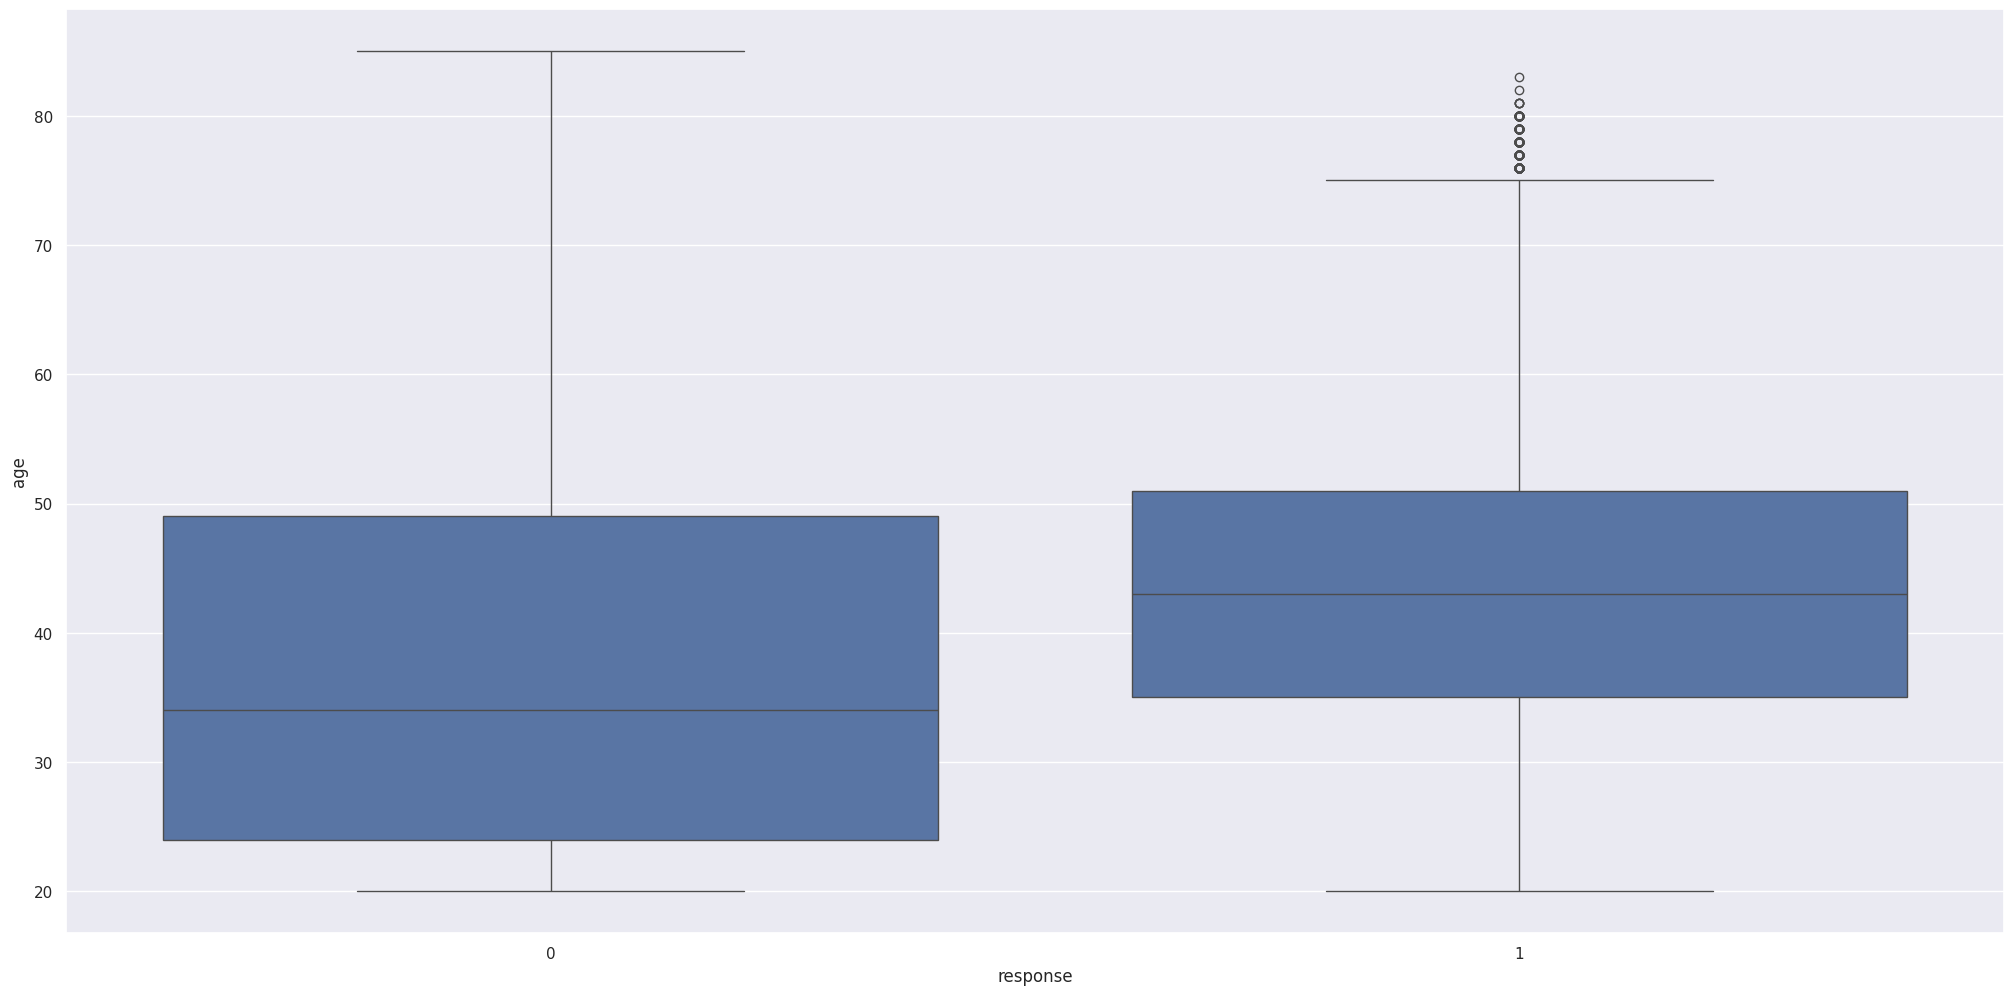

In [18]:
# age
sns.boxplot( x='response', y='age', data=df4)

[Text(0.5, 1.0, 'Response = 1')]

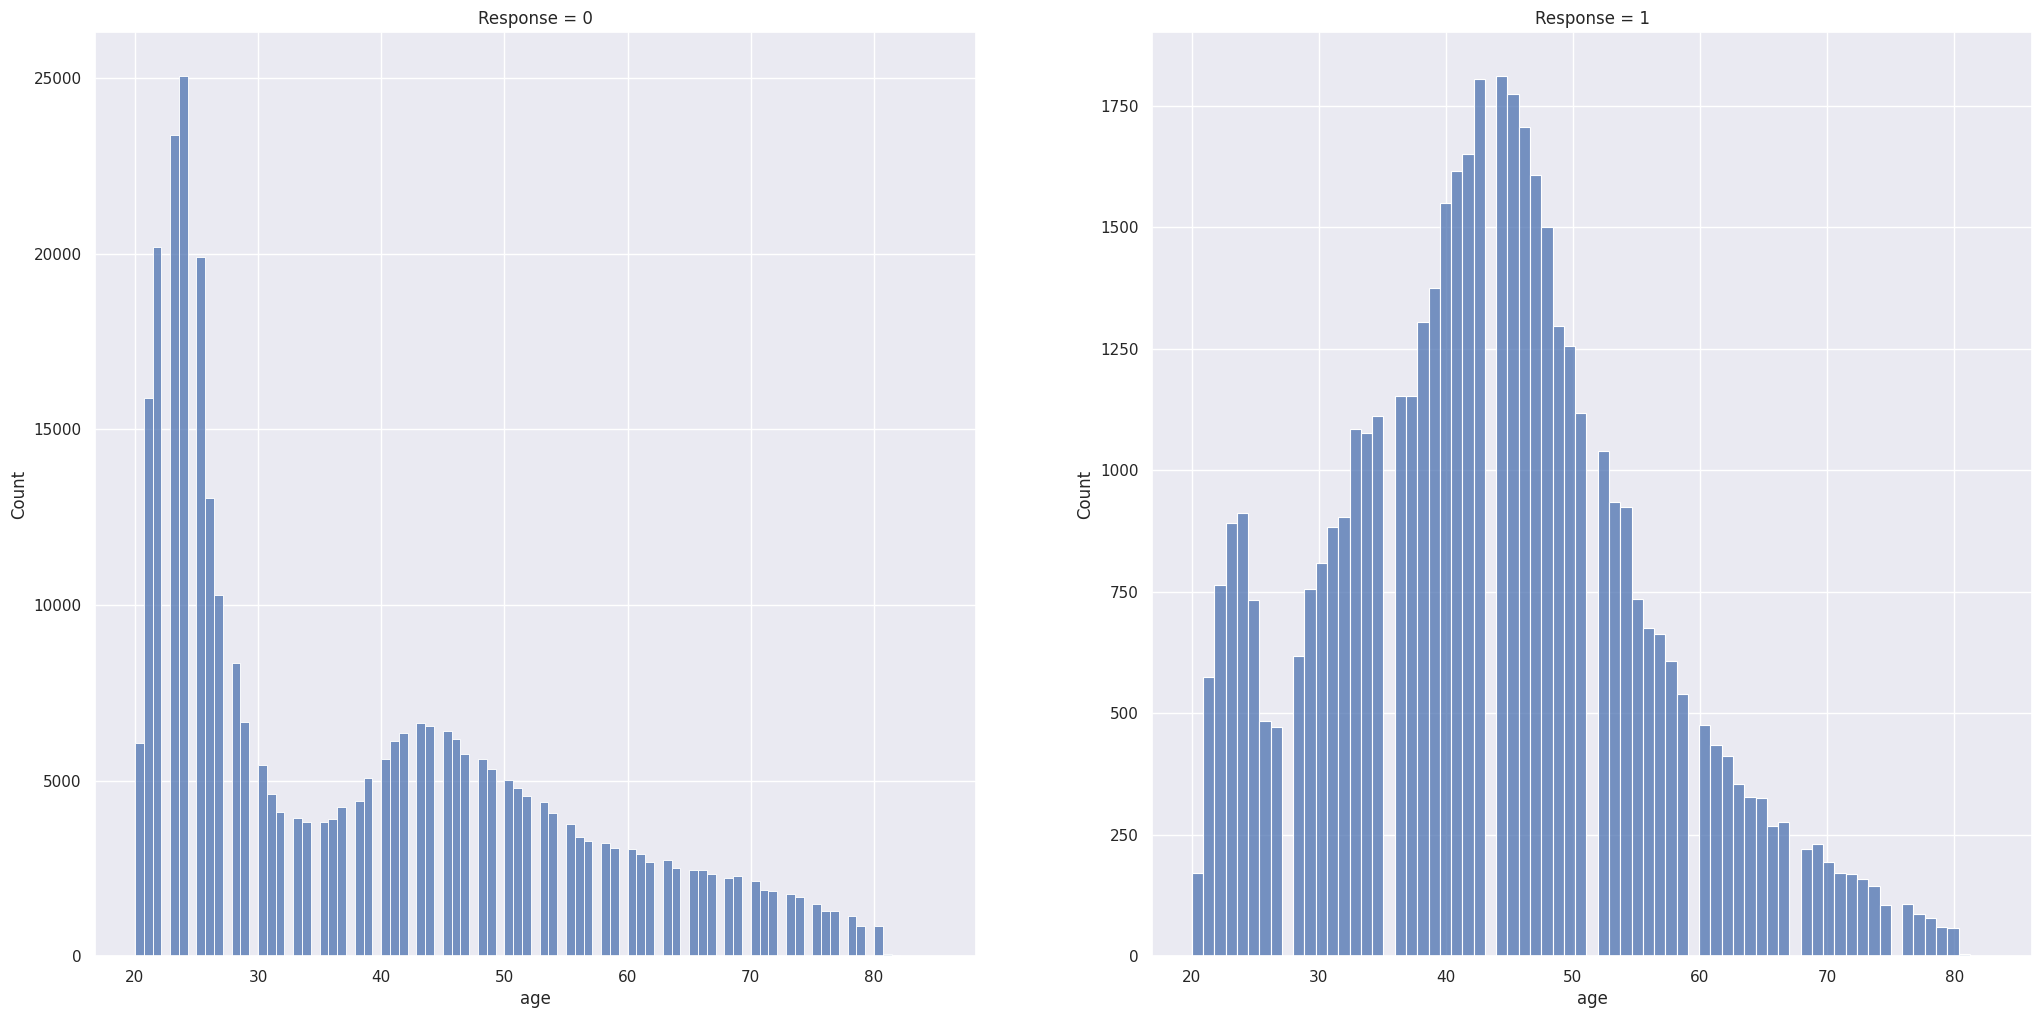

In [19]:
plt.subplot( 1, 2, 1)
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00 ).set(title='Response = 0')

plt.subplot(1, 2, 2)
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 ).set(title='Response = 1')

<Axes: xlabel='response', ylabel='annual_premium'>

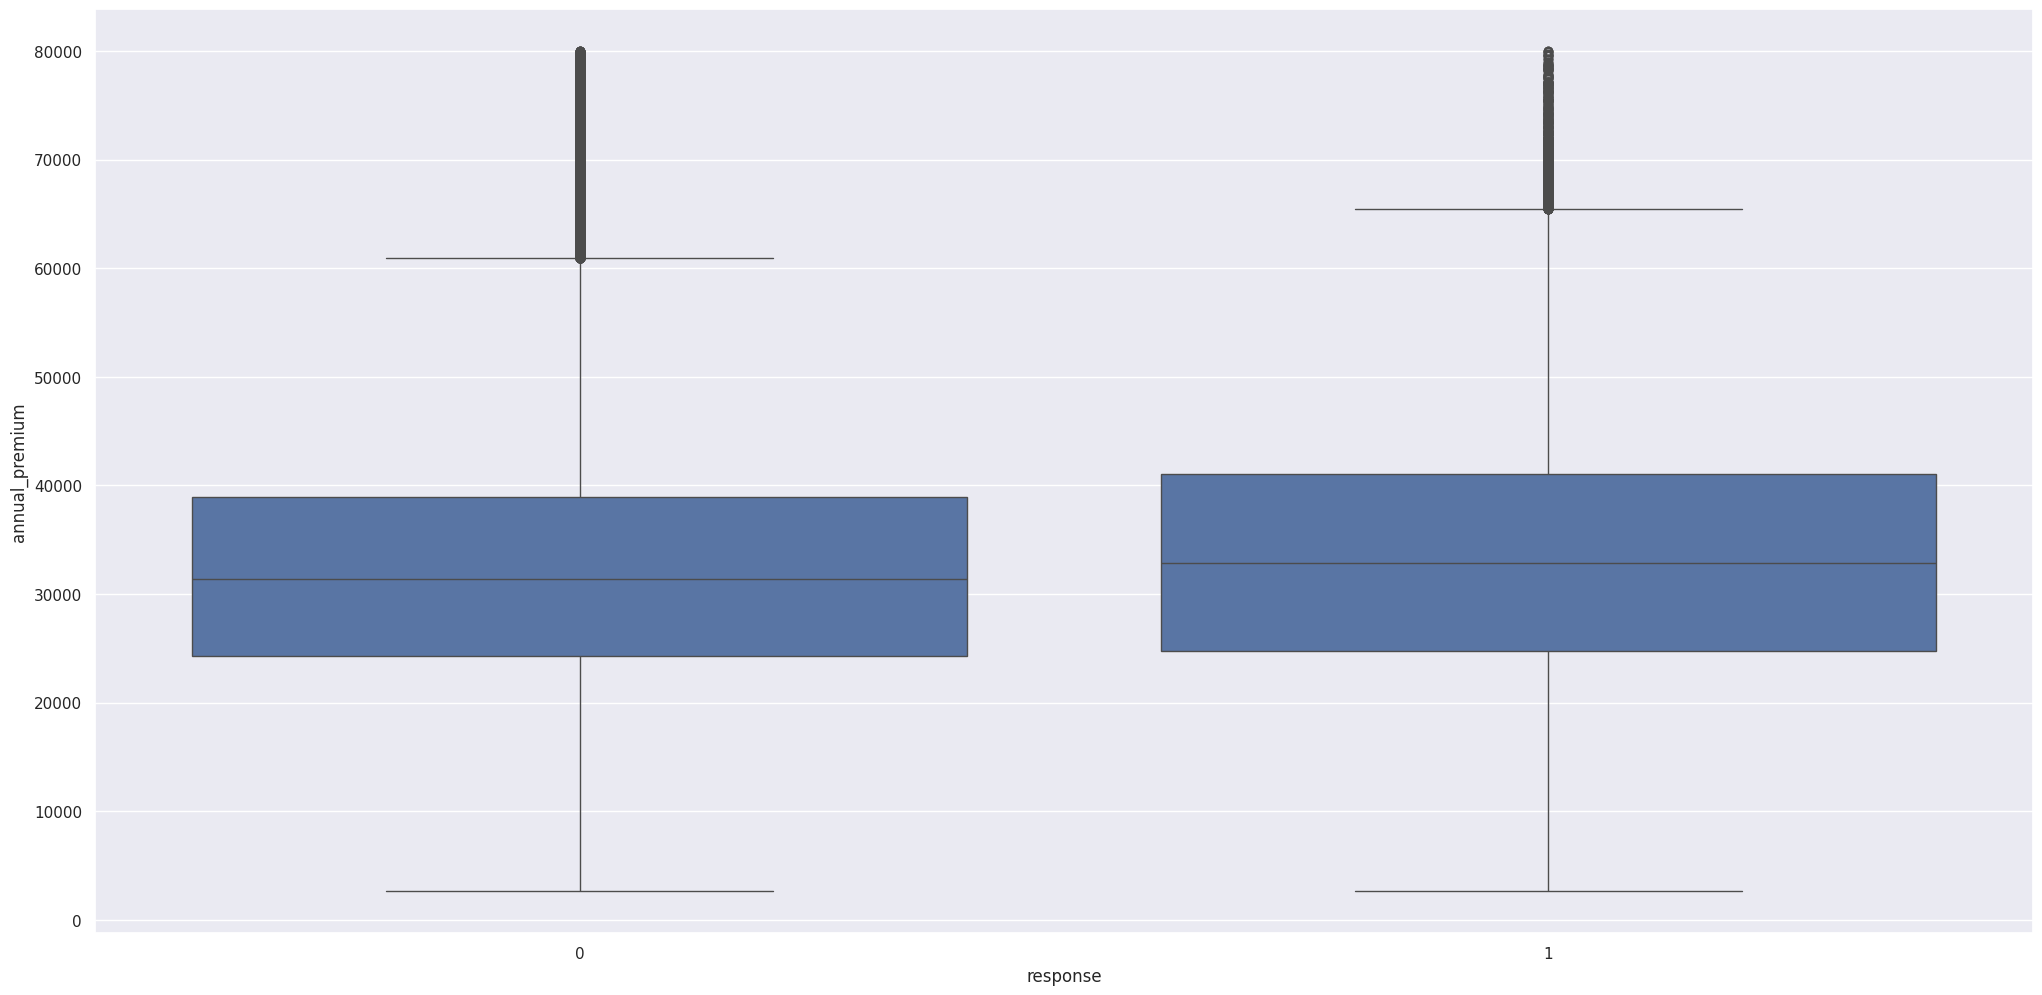

In [20]:
# annual_premium
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux)

[Text(0.5, 1.0, 'Response = 1')]

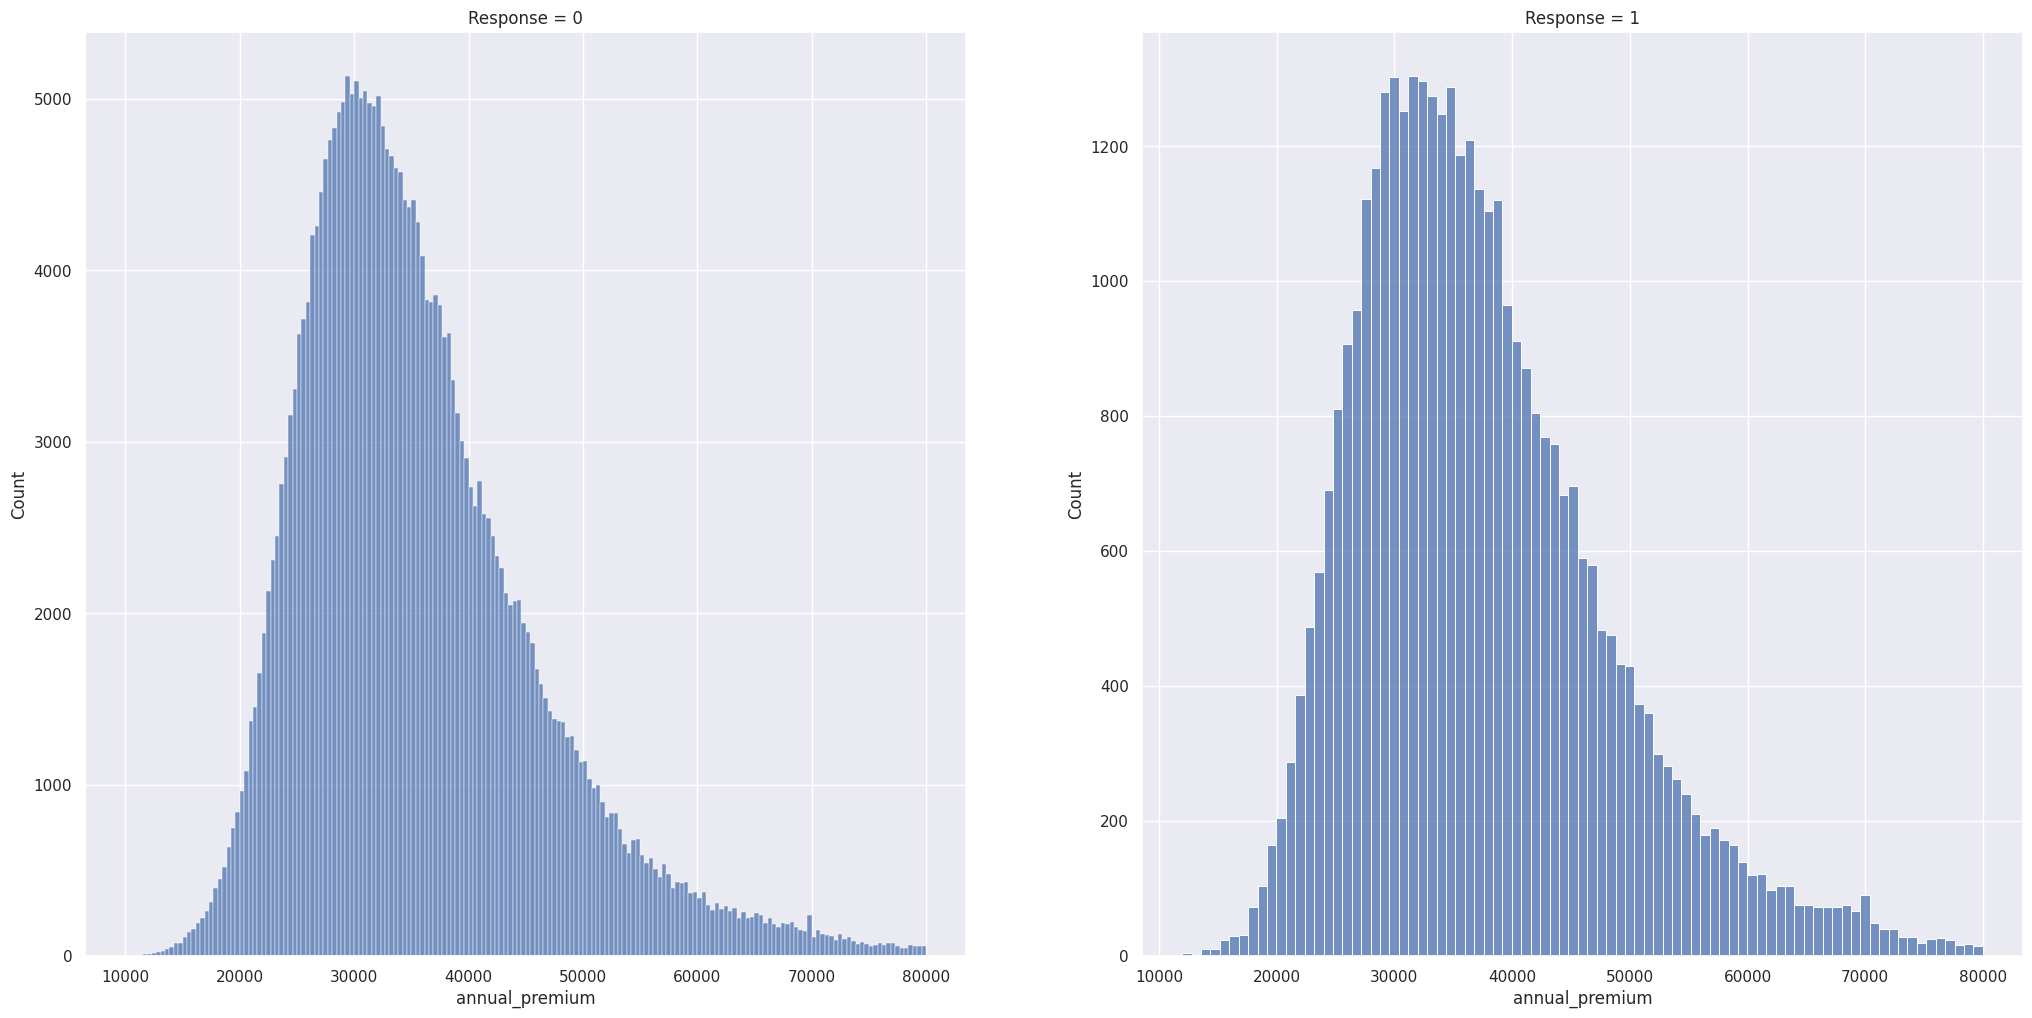

In [21]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

plt.subplot( 1, 2, 1)
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot( aux00 ).set(title='Response = 0')

plt.subplot(1, 2, 2)
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot( aux00 ).set(title='Response = 1')

<Axes: xlabel='response', ylabel='driving_license'>

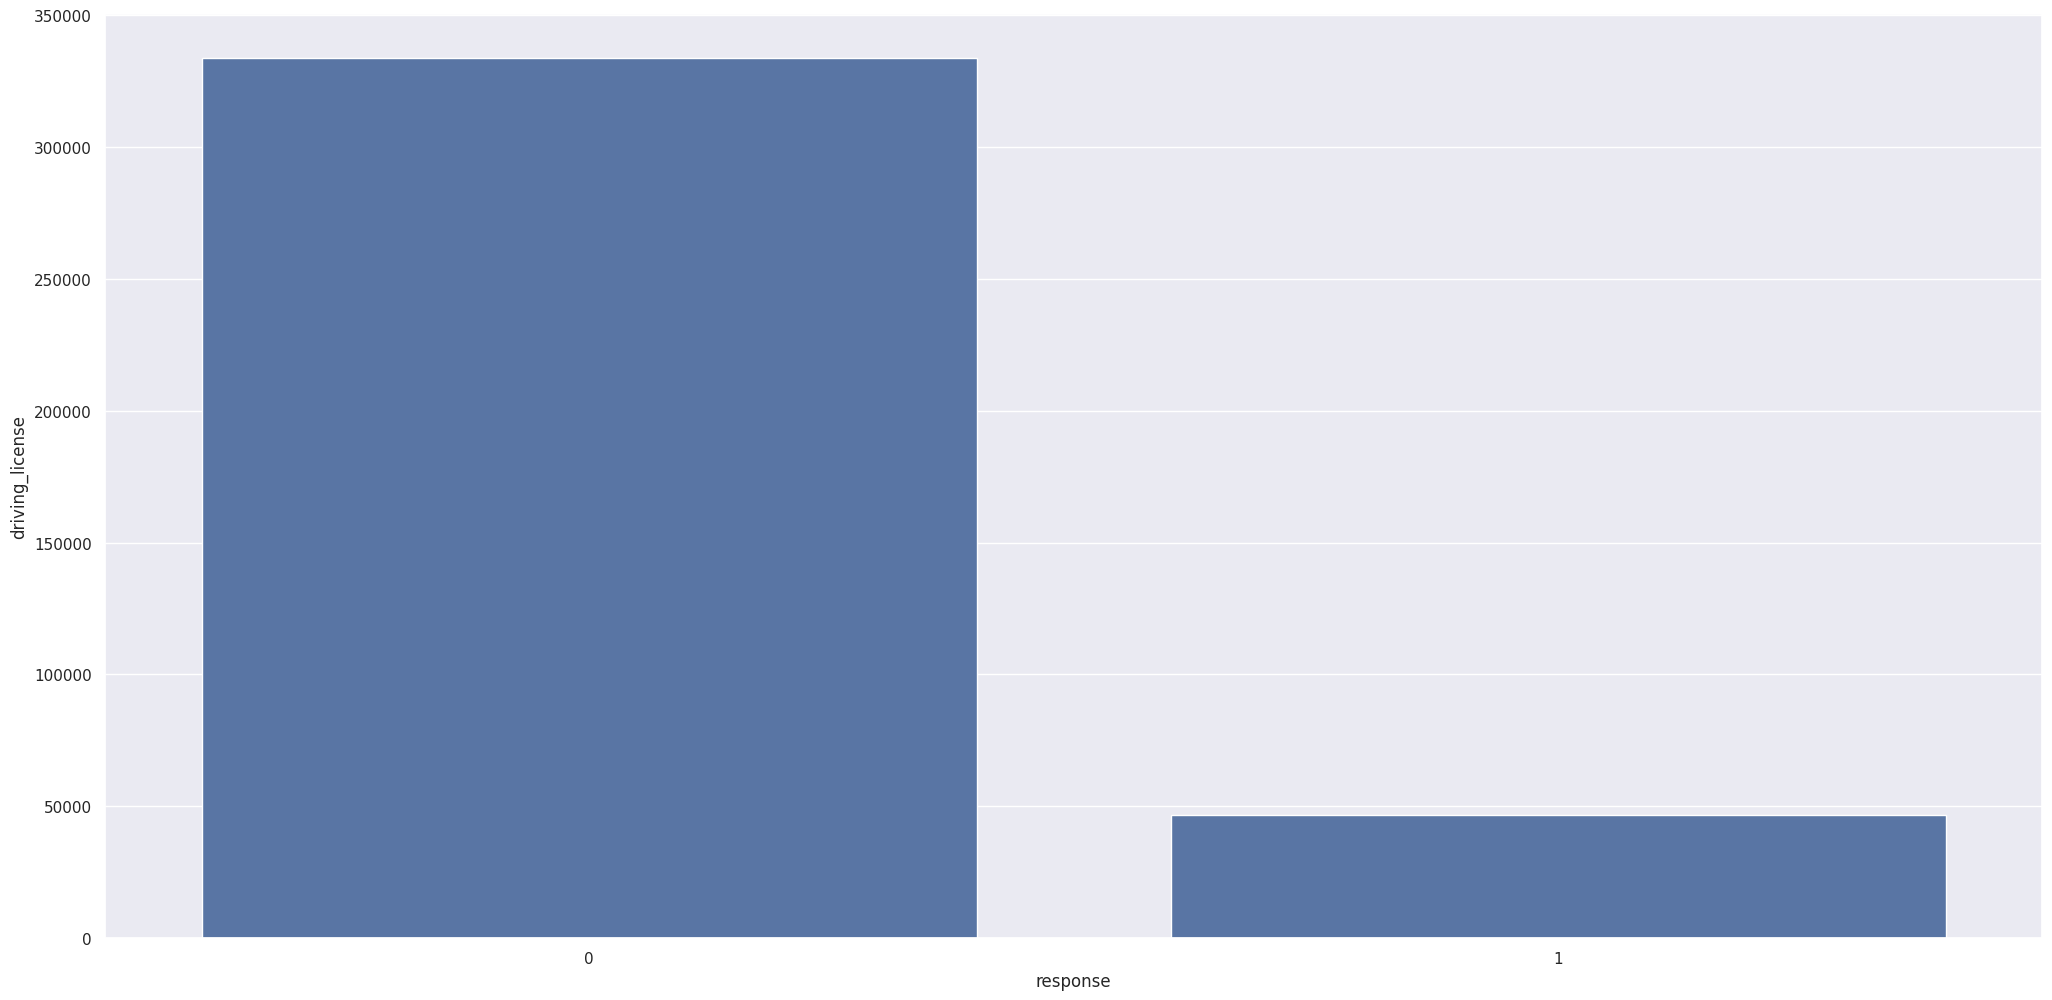

In [22]:
# driving_license
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
aux.head()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()

sns.barplot( x='response', y='driving_license', data=aux)

<Axes: xlabel='region_code', ylabel='id'>

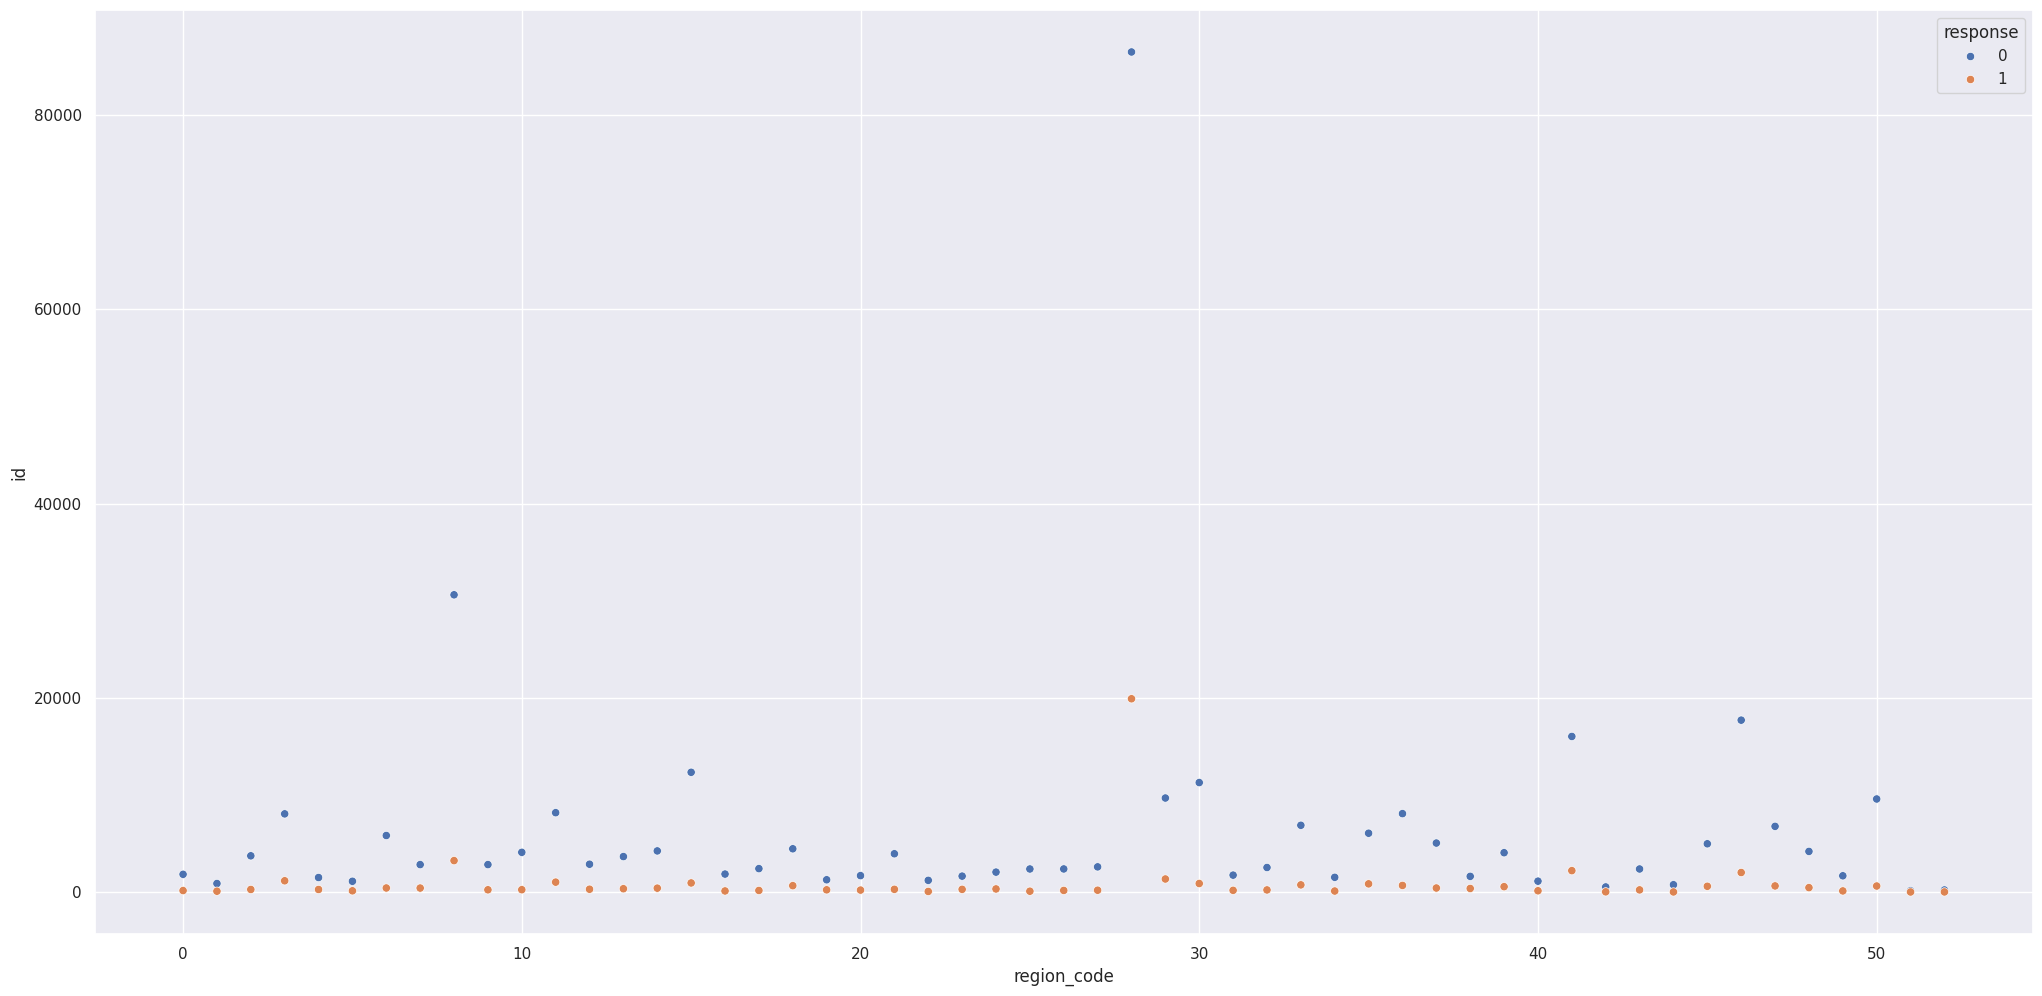

In [23]:
# region_code
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code','response'] ).count().reset_index() 

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0)

In [24]:
# gender

In [25]:
# previously_insured
df4[['previously_insured', 'response']].head()
pd.crosstab(df4['previously_insured'], df4['response']).apply( lambda x: x / x.sum(), axis = 1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [26]:
# vehicle age
df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index()

,vehicle_age,response,proportion
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


<Axes: xlabel='response', ylabel='policy_sales_channel'>

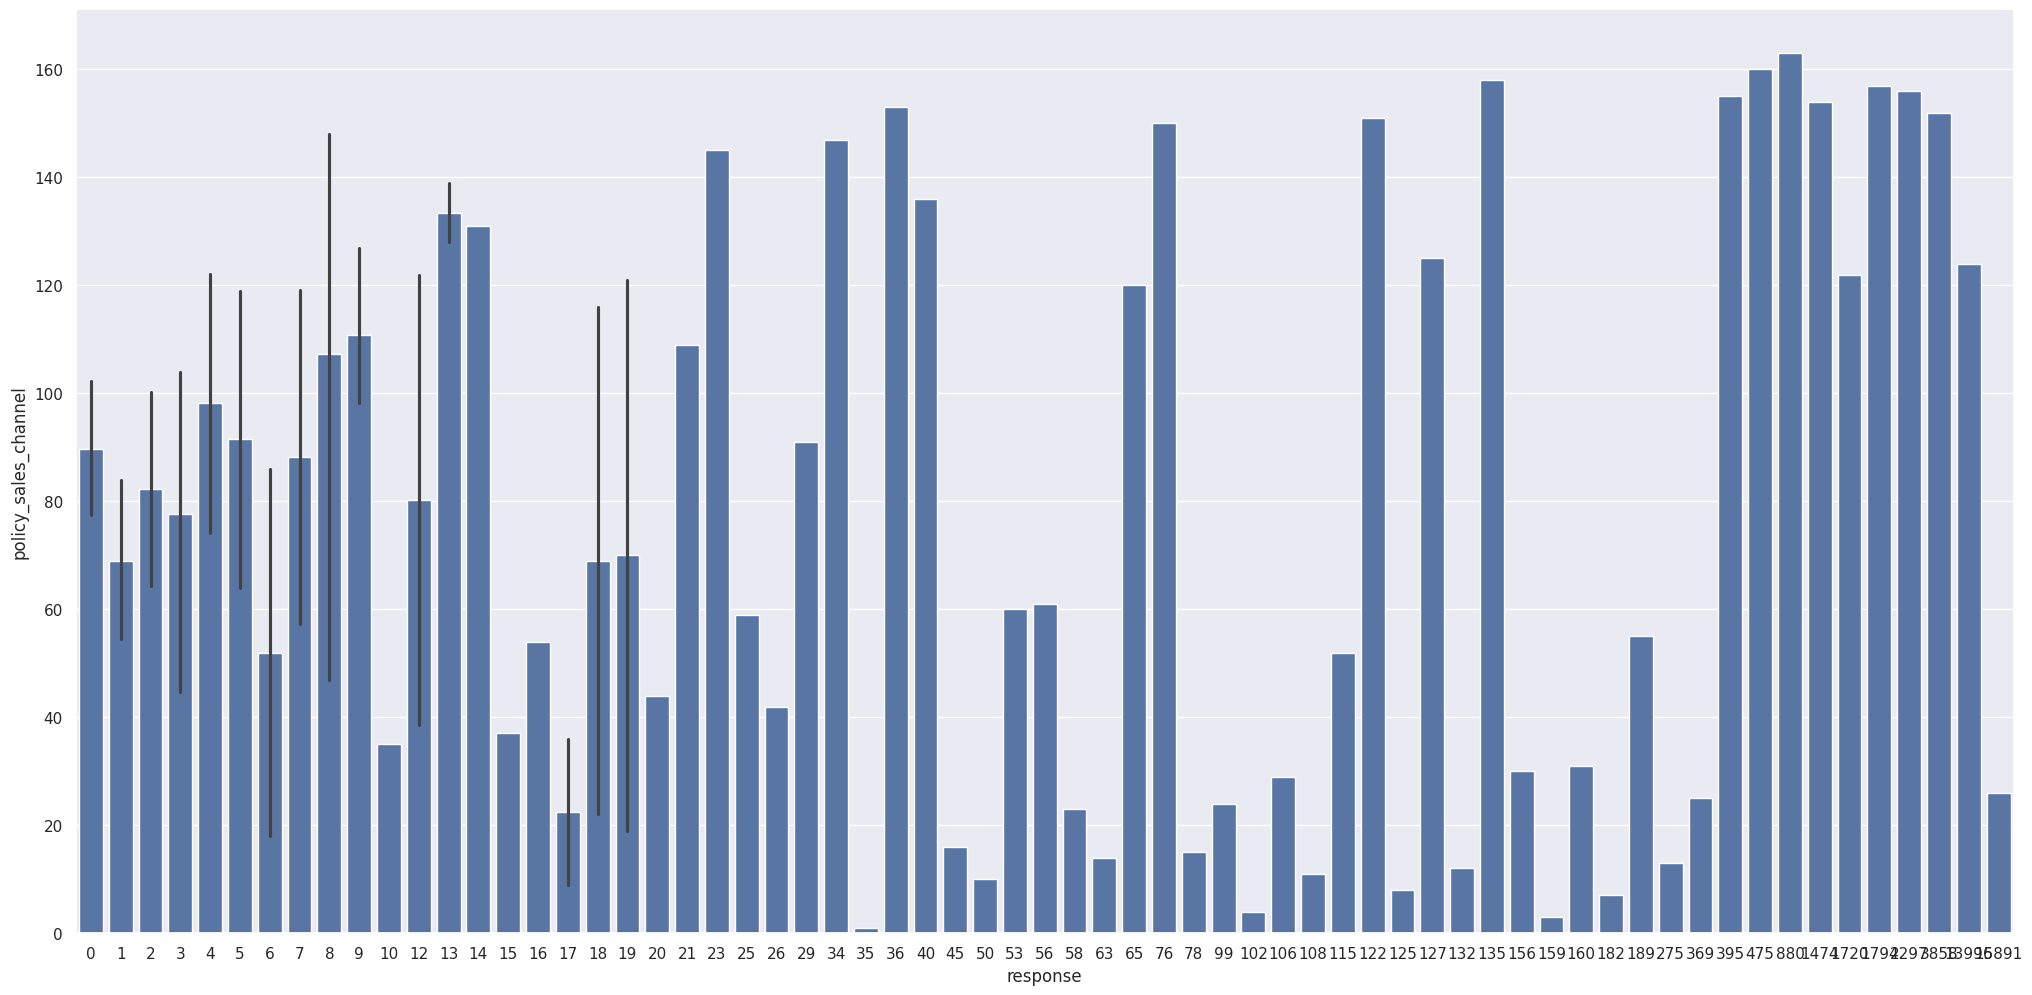

In [27]:
# policy_sales_channel
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux)

<Axes: xlabel='response', ylabel='vintage'>

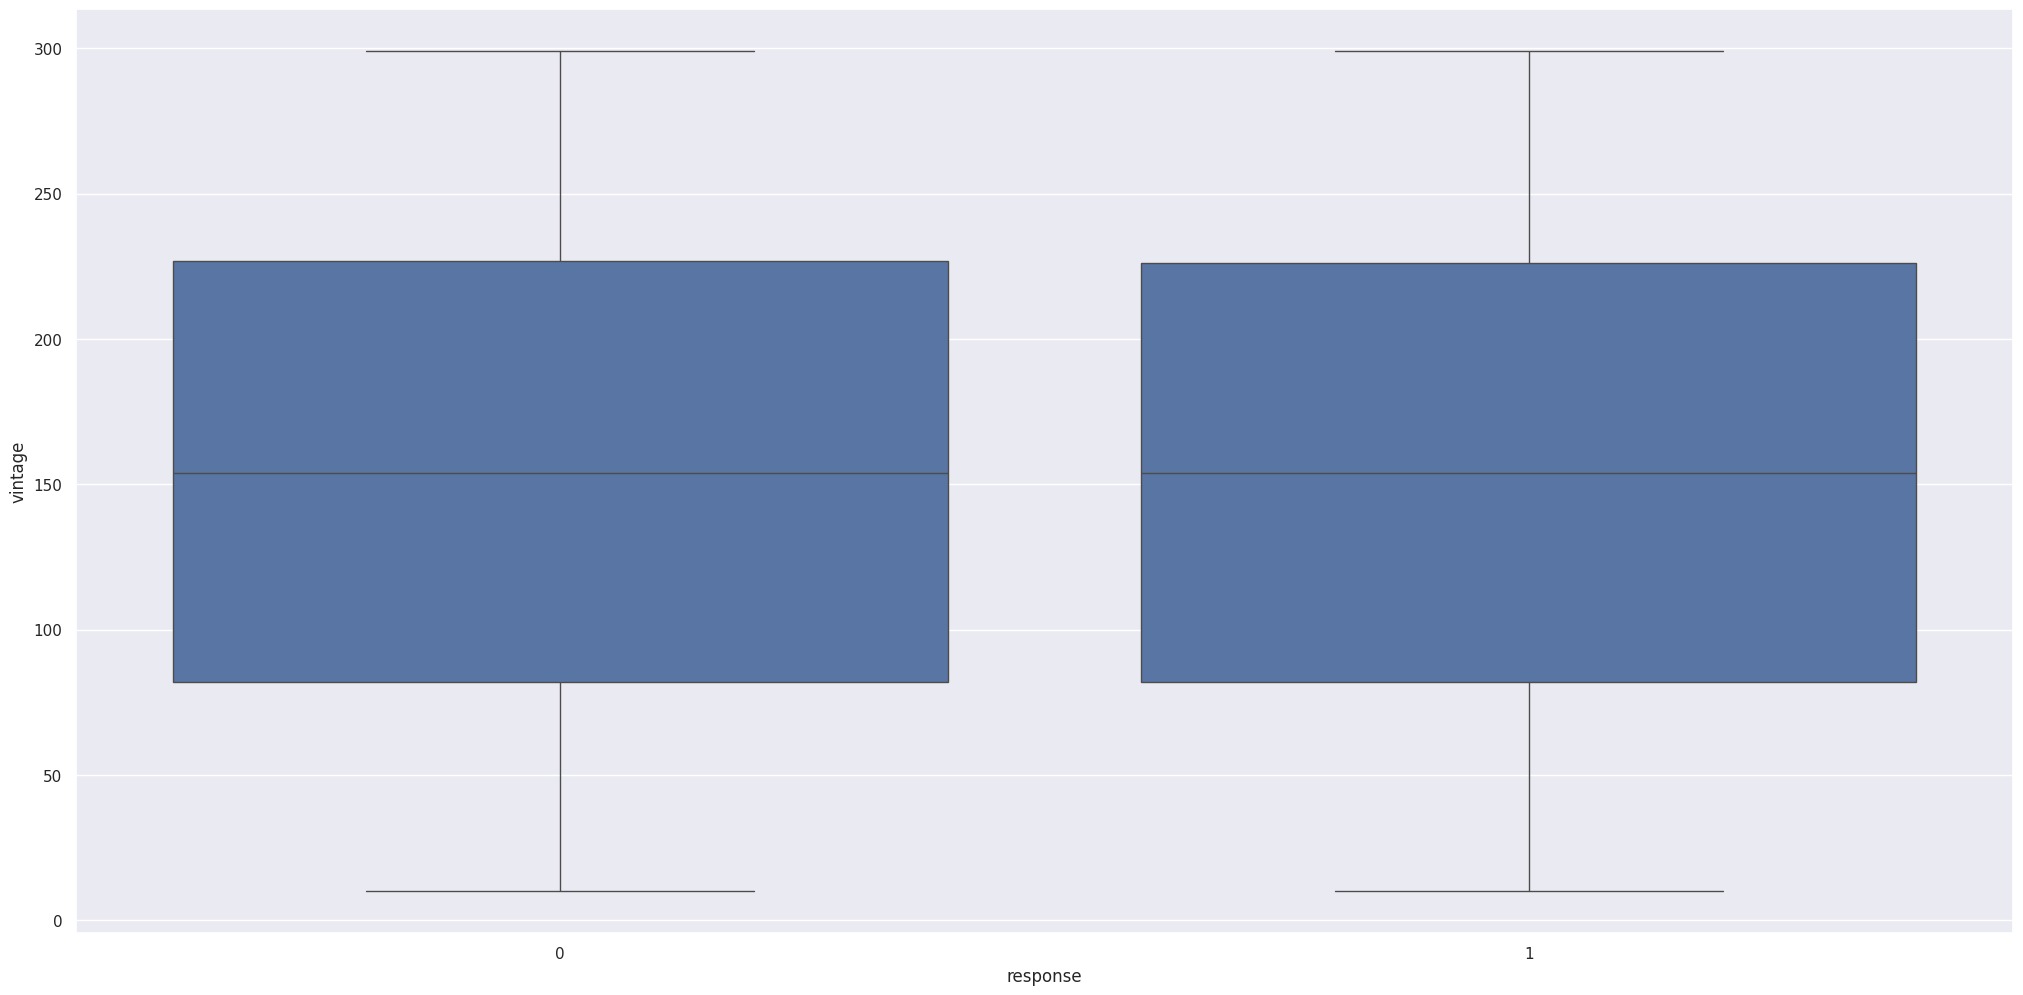

In [28]:
# vintage
sns.boxplot( x='response', y='vintage', data=df4)

[Text(0.5, 1.0, 'Response = 1')]

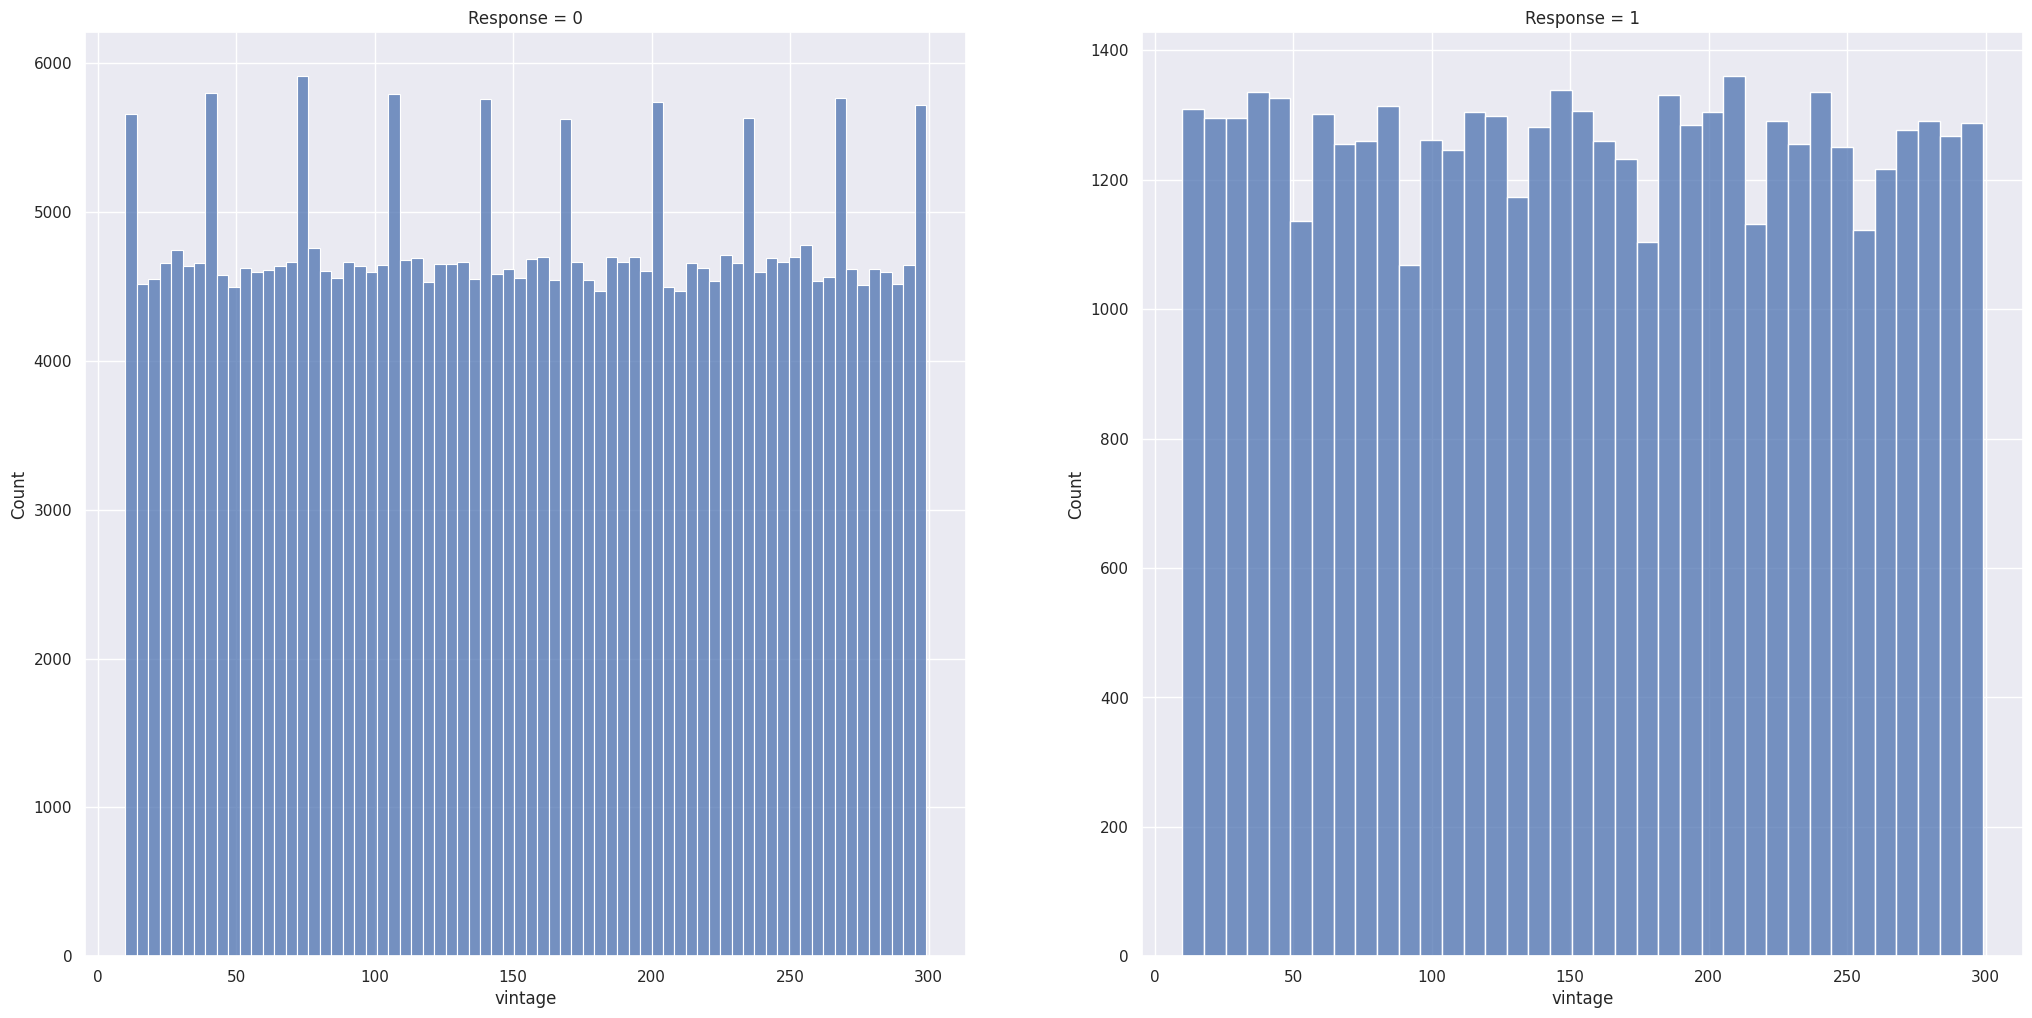

In [29]:
plt.subplot( 1, 2, 1)
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux00 ).set(title='Response = 0')

plt.subplot(1, 2, 2)
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux00 ).set(title='Response = 1')

# 5.0. Data Preparation

In [30]:
df5 = df4.copy()

In [31]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.20)

df5 = pd.concat( [x_train, y_train], axis=1)

## Standardization

In [32]:
ss = pp.StandardScaler()

#annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

## Reescaling

In [33]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# vintage
df5['vintage'] = mms_age.fit_transform( df5[['vintage']].values )

## Encoder

In [34]:
# gender - Target Enconding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5.loc[:, 'gender'].map( target_encode_gender)

# region_code -  Frequency Encoding / Target Encoding  / Weighted Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )

# vehicle_age - One Hot Enconding / Order Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel  - Target Encoding / Frequency Ecoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )

## 5.4 Validation Preparation 

In [35]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map( target_encode_gender)

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values)

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'gender'].map( target_encode_region_code)

# vehicle age
x_validation.loc[:, 'vehicle_age'] = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.fit_transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['region_code'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_age.fit_transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

/tmp/ipykernel_2221/2231811836.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.05536332 0.12110727 0.1349481  ... 0.03806228 0.03806228 0.04844291]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values)
/tmp/ipykernel_2221/2231811836.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.17301038 0.52941176 0.66782007 ... 0.29411765 0.21107266 0.47750865]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x_validation.loc[:, 'vintage'] = mms_age.fit_transform( x_validation[['vintage']].values )
/tmp/ipykernel_2221/2231811836.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=Fa

# 6.0. Feature Selection

## 6.2 Features Importance

In [36]:
# model_definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis = 1)
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n)

,n_estimators,250
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


Feature ranking:
                        feature  importance
0                       vintage    0.273295
0                annual_premium    0.244773
0                           age    0.164871
0                   region_code    0.104948
0                vehicle_damage    0.066346
0          policy_sales_channel    0.060035
0            previously_insured    0.057958
0      vehicle_age_below_1_year    0.013722
0  vehicle_age_between_1_2_year    0.006352
0                        gender    0.004858
0      vehicle_age_over_2_years    0.002323
0               driving_license    0.000518


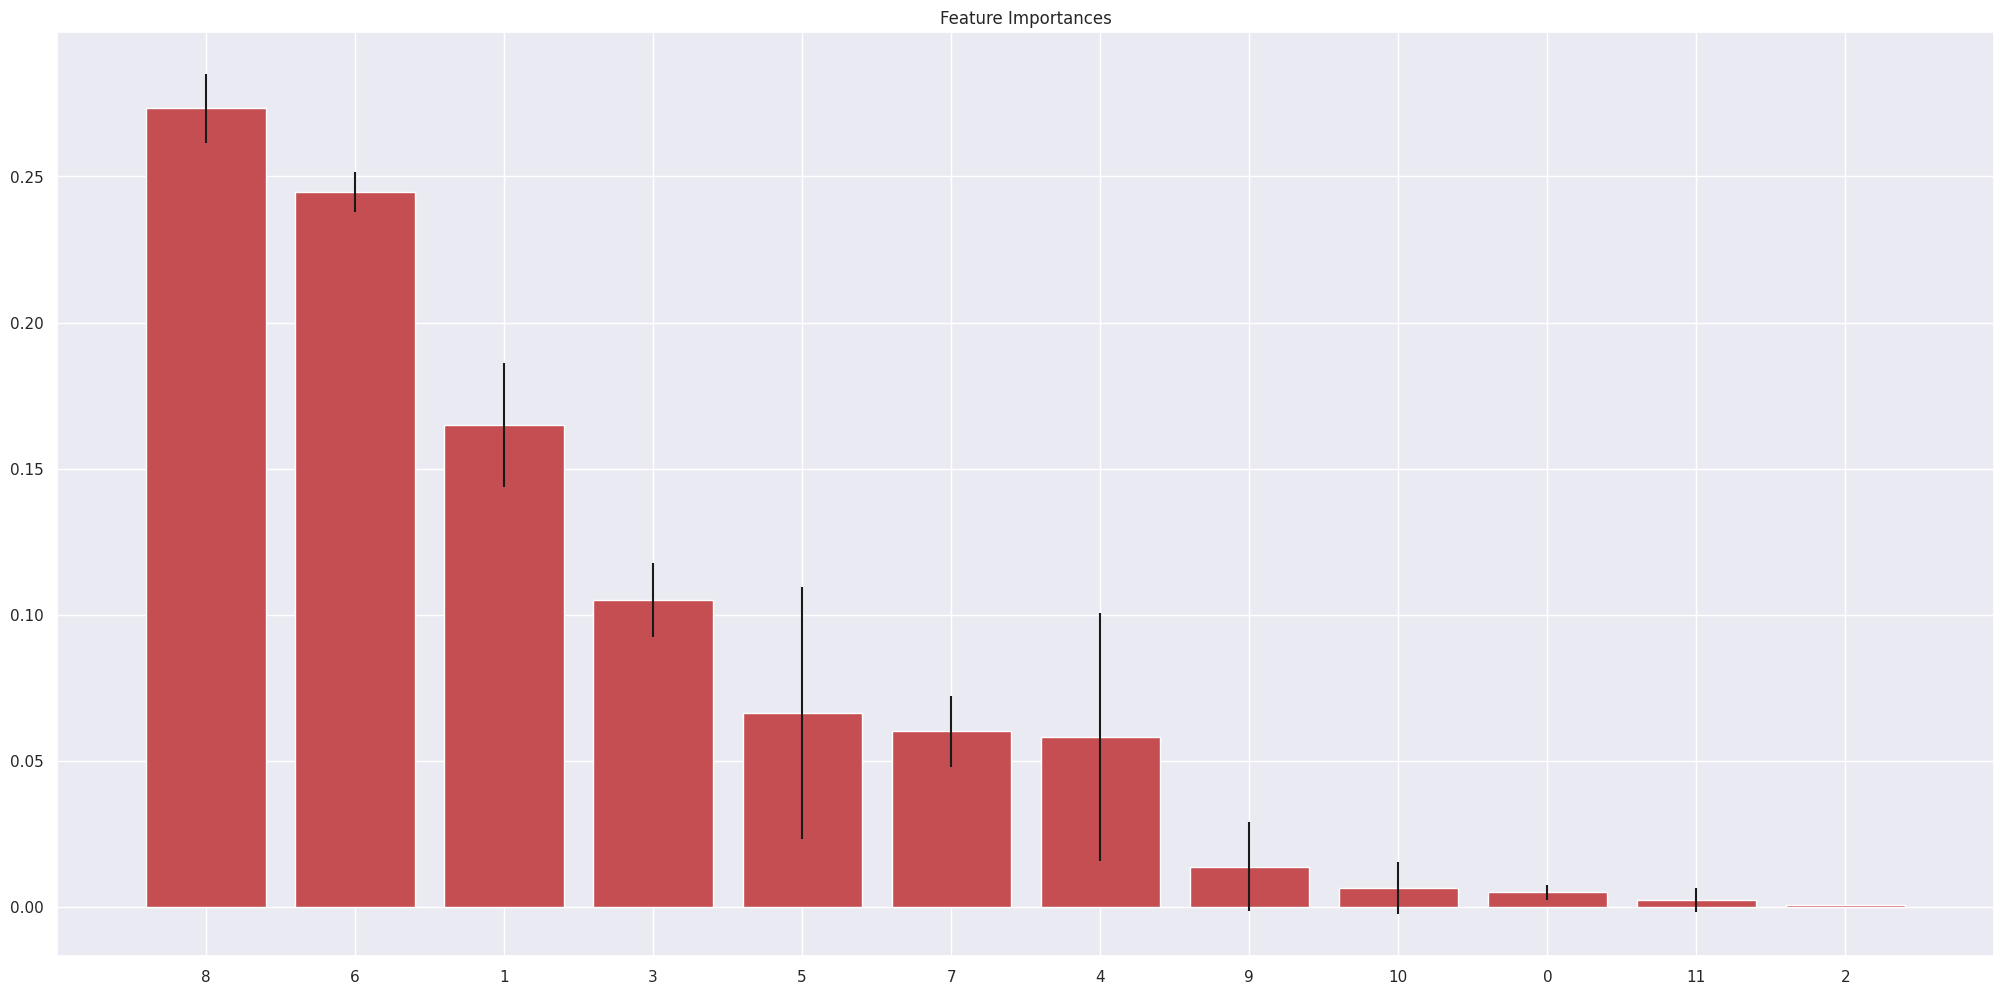

In [37]:
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

# Print the feaature ranking
print("Feature ranking:")
df = pd.DataFrame()

for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )

print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature Importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. Machine Learning

In [38]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_train = df5[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 7.1. KNN

In [39]:
# model_definition 
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model_training
knn_model.fit( x_train, y_train)

# model_prediction - Poder de generalizacao
yhat_knn = knn_model.predict_proba( x_val )

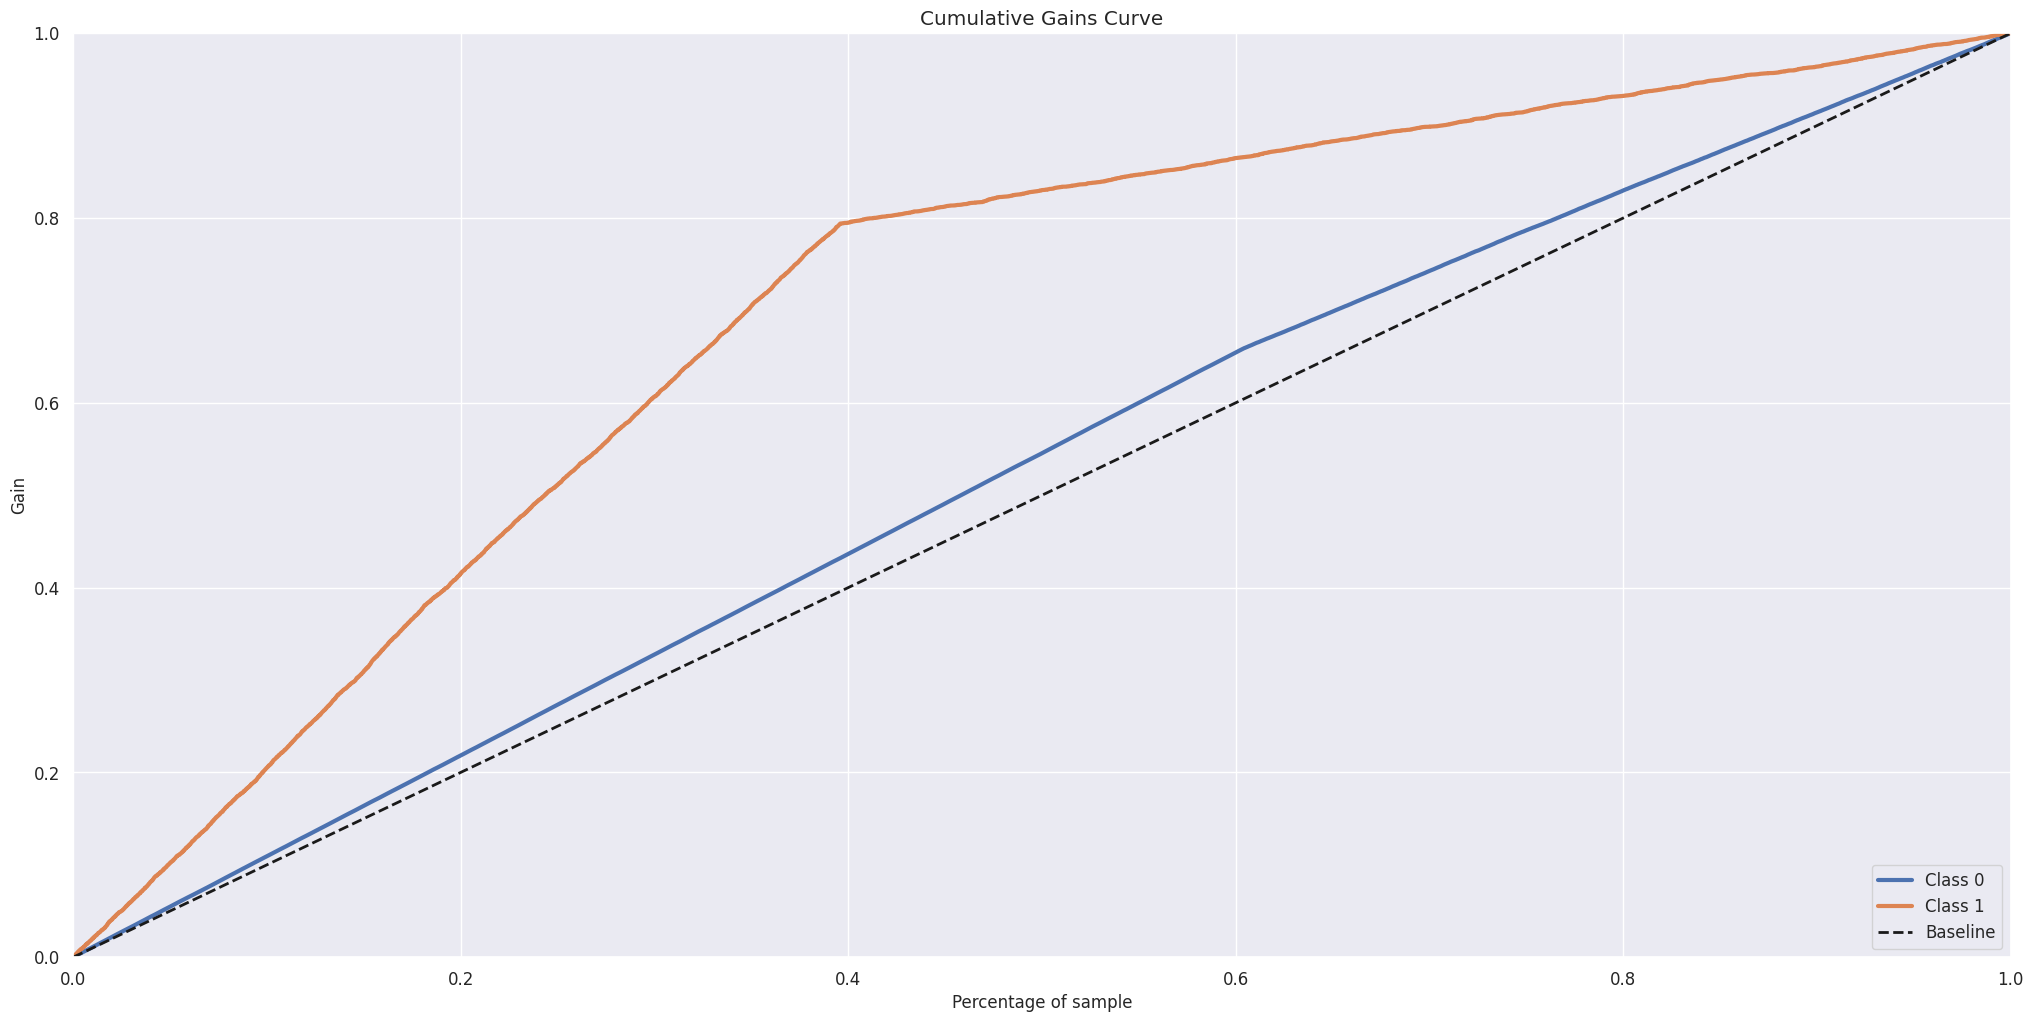

In [40]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

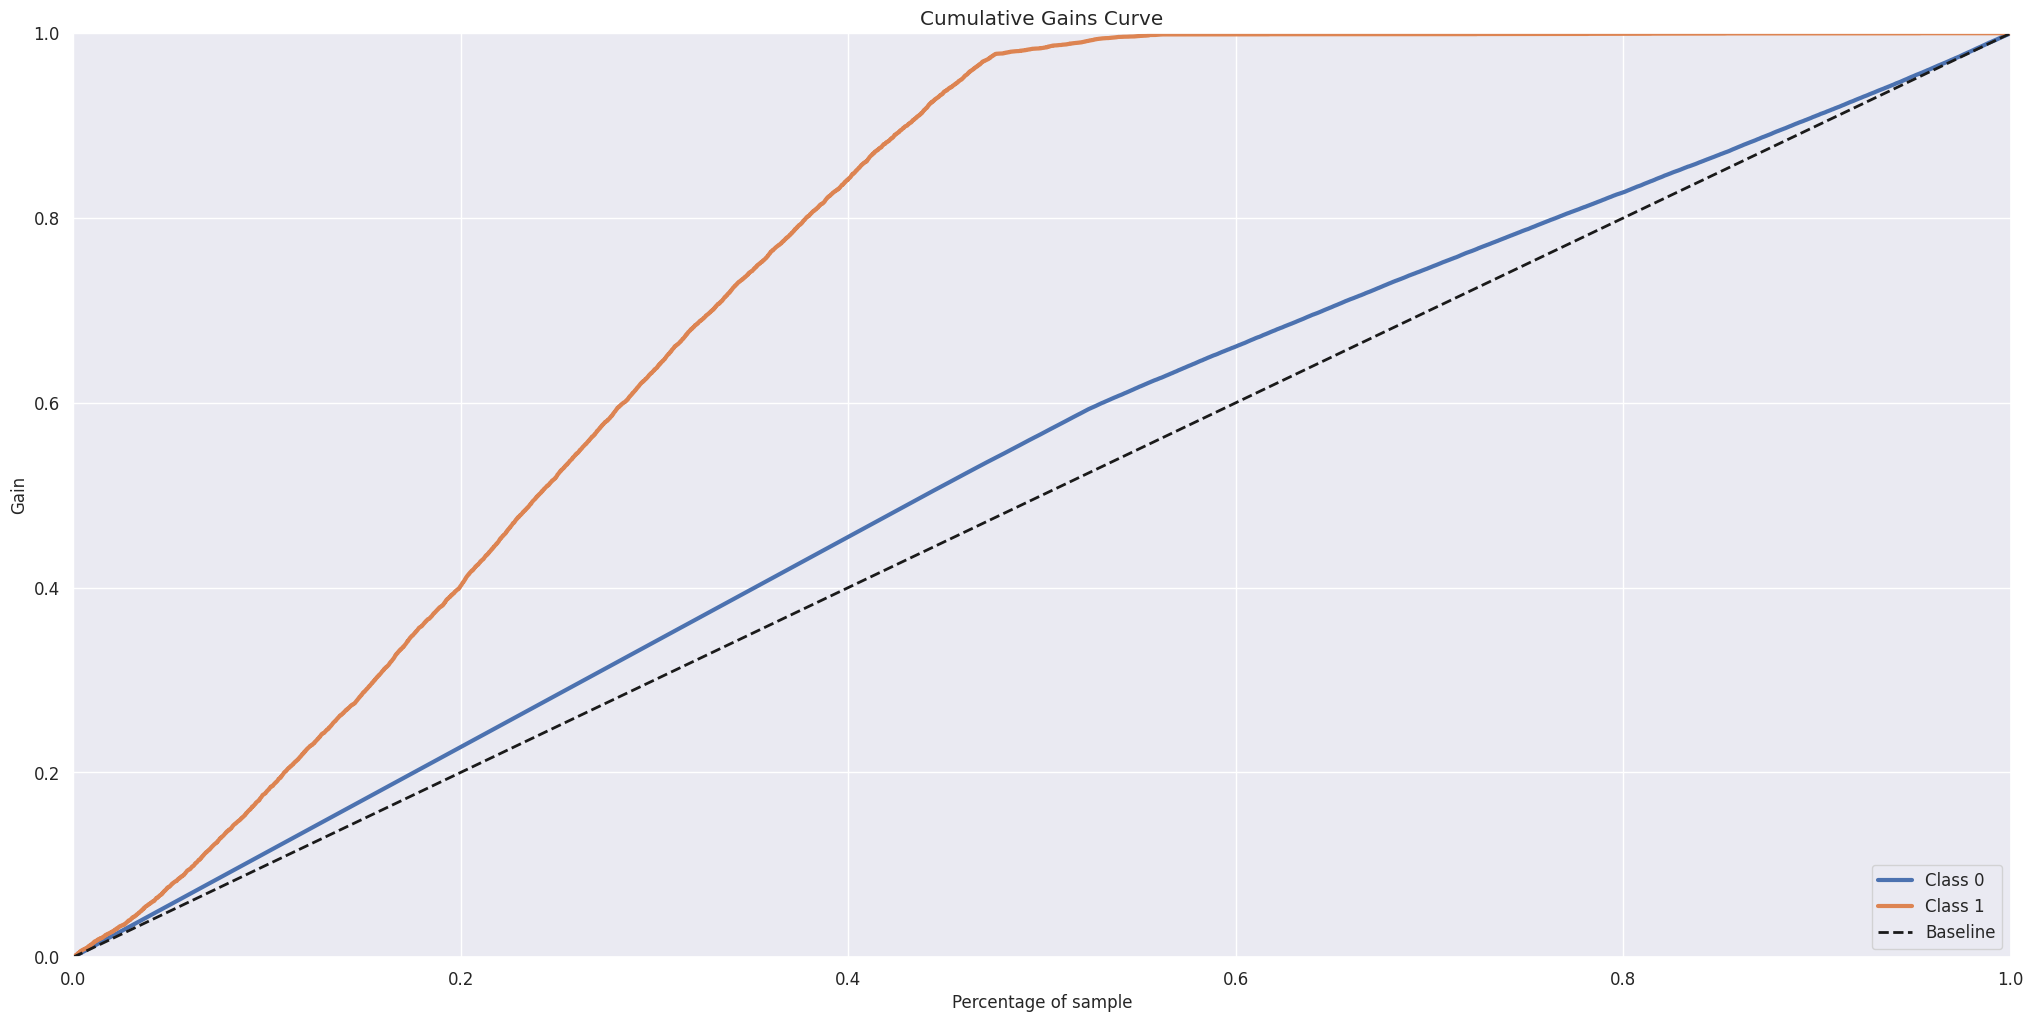

In [41]:
# model definition
lr_model = lr.LogisticRegression( random_state=42 )

# model training
lr_model.fit( x_train, y_train)

# model_prediction - Poder de generalizacao
yhat_lr = lr_model.predict_proba( x_val )

skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

## 7.2. Extra Trees

In [42]:
# Model definition
et = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model fit
et.fit( x_train, y_train)

# model predict
yhat_et = et.predict_proba( x_val )

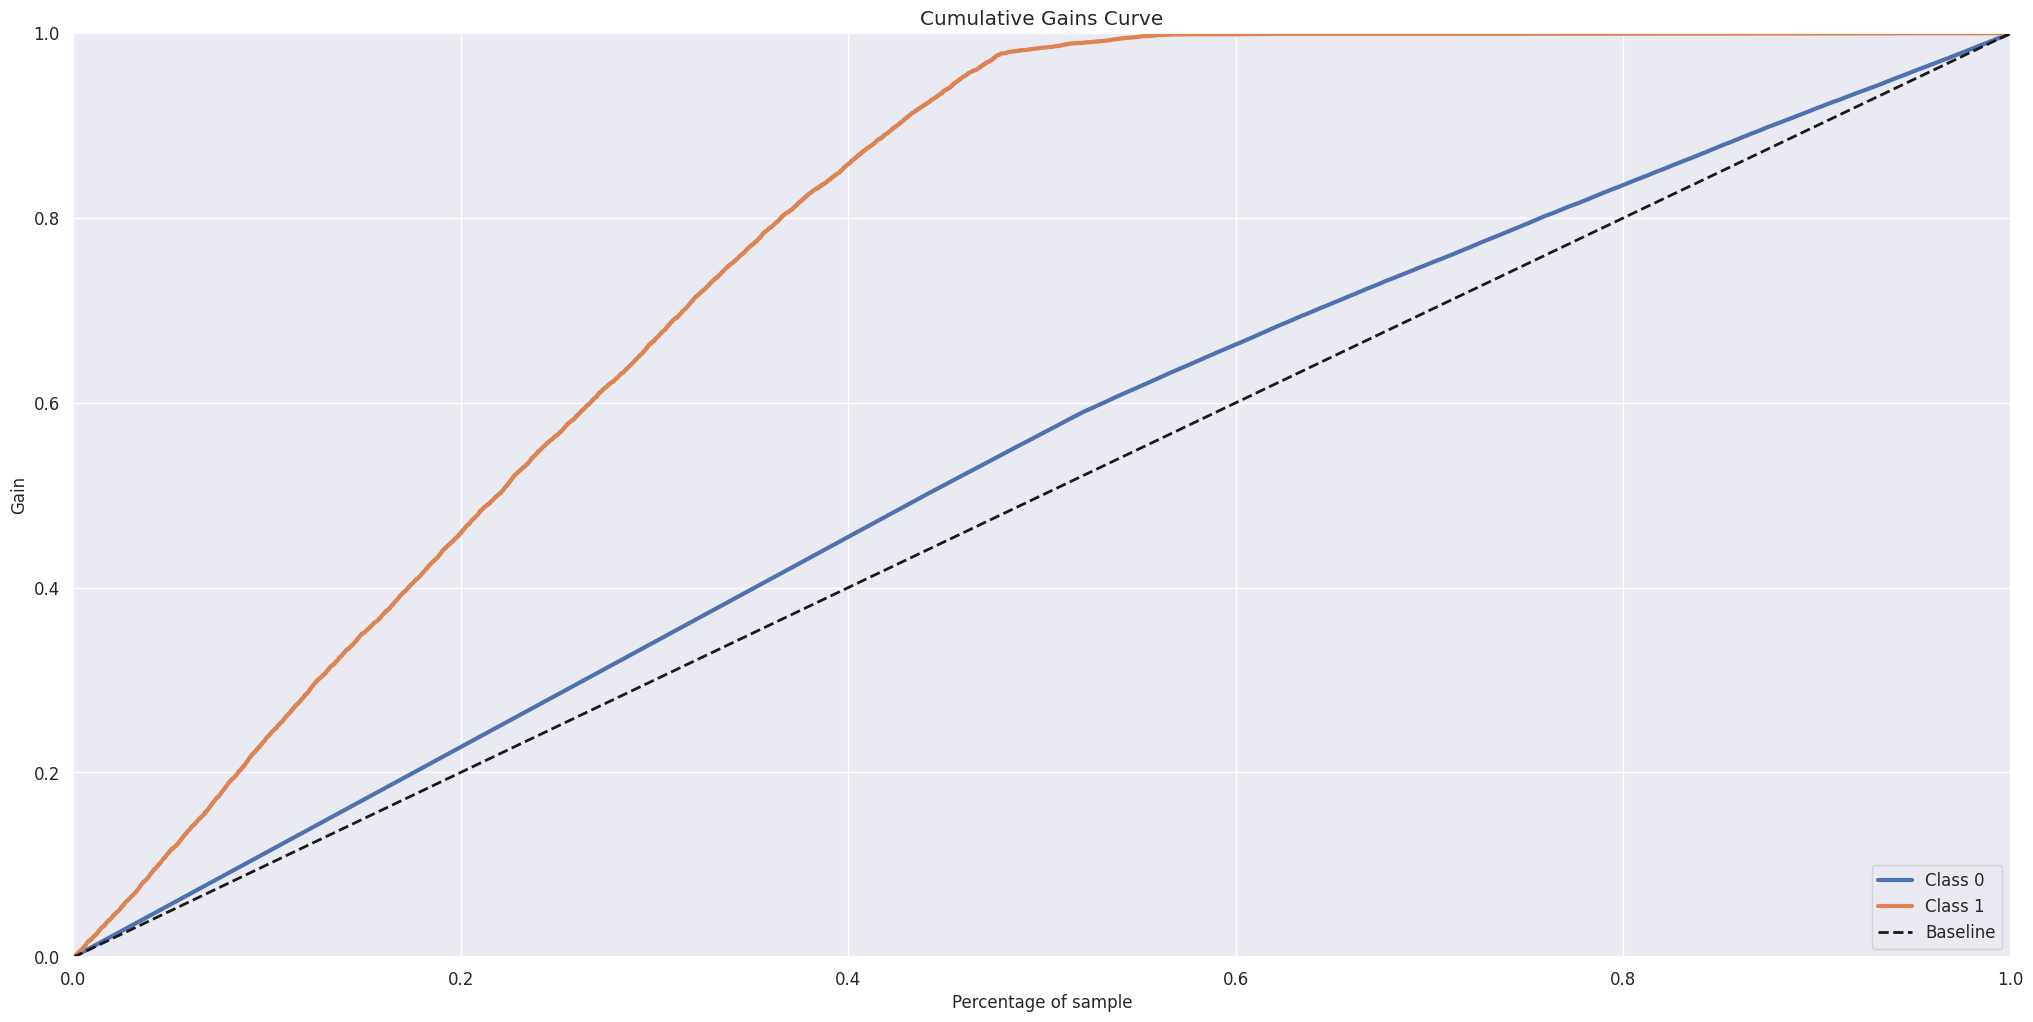

In [45]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

# 8.0. Model Performance

In [72]:
def precision_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )
    
    # create ranking order
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

In [75]:
def recall_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )
    
    # create ranking order
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

In [77]:
# copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity_score
df8['score'] = yhat_knn[:, 1].tolist()

# sort by propensity_score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k
precision_at_50 = precision_at_k(df8, k=50)
print('Precision at K: {}', format(precision_at_50) )

# compute recall at k
recall_at_50 = recall_at_k(df8, k=50)
print('Recall at K: {}', format(recall_at_50) )

Precision at K: {} 0.27450980392156865
Recall at K: {} 0.0015169574168382273
